# Final Workflow StatsLab

### Contents:
* [0. Overview](#overview)
    * [Our Objective](#objective)
    * [Gaussian Processes and Implementation](#gaussian-processes)
    * [Using This File to Identify Hotspots](#hotspots)
* [1. Helper Functions](#helpers)
* [2. Plots](#plots)
* [3. Workflow Illustration](#workflow)
    * [3.0 Preprocessing Data](#prepro)
    * [3.1 Fitting the Model from Scratch](#scratch)
    * [3.2 Plotting Previous Results](#plot-previous)
    * [3.3 Comparing Models in Different Time Brackets](#time-comparison)

## 0. Overview <a class="anchor" id="overview"></a>

### Objective: Determine Whether PM2.5 Hotspots are Genuine <a class="anchor" id="objective"></a>

Our main objective is to devise a method for assessing the confidence that an identified hotspot is a genuine hotspot, in the context of PM2.5 air pollution. We use data collected in Kigali, Rwanda, in September 2021. The team at Open Seneca fitted sensors to the bikes of twenty local delivery drivers, and gathered data about the ambient PM2.5 pollution they encountered over the course of the month. Keep in mind, though, that the _method_ we devise to identify genuine hotspots is more relevant than the genuine hotspots we identify in Kigali. We intend that the method be applicable to Open Seneca’s PM2.5 data from other cities.

The ‘hotspots’ are neighborhoods more polluted than some baseline level in the surrounding city. Just looking at the locations with the highest pollution measurements does not immediately reveal all hotspots. Pollution follows several temporal patterns, so one must adjust for the time at which measurements are made. Measurements are also geographically sparse; in a short time frame, the delivery drivers will only travel on so many roads. In order to make city-wide pollution comparisons, one must therefore leverage the available data to make predictions about the un-measured neighborhoods.

We propose adjusting for the temporal pattern by de-trending the data. Three baselines are computed: a 15-minute baseline, a daily baseline, and a baseline combining these two. A baseline is the rolling average of all measurements in the given time period. According to the number of active measurement devices and the dynamics of pollution in the city, an analyst can choose which of these baselines is most appropriate - and subtract it from the measurements to de-trend them.

Then we fit a Gaussian Process model, with PM2.5 pollution as the dependent variable and latitude & longitude as the independent variables. The idea is that we estimate a flexible regression surface across the whole city of Kigali for the mean pollution level in each spot. Equipped with a prior distribution, the Gaussian Process model allows for the construction of confidence intervals, and thus the assessment of how likely it is that any point in the city is a genuine hotspot. 

_Please consult the Gaussian Processes handout for technical details!_


### Using Gaussian Process Regression to Identify Air Pollution Hotspots <a class="anchor" id="gaussian-processes"></a>

To use gaussian process regression to identify airquality hotspots specifically, we have to overcome a few problems
- Number of observations (GP regression has complexity of $\mathcal{O}(n^3)$ so using all observations is not feasible) 
- Sparsity of extreme values (random subsampling to solve the complexity issue is not sufficient) 
- Kernel choice to encode a priori assumption on true surface of air pollution

In the following, we quickly address how we solve these three main problems and how they are implemented.
We employ an ensemble of gaussian processes regressions on subsamples of the data to reduce the run-time 
complexity. In the same step, we address the sparsity issue. 

The steps detailed in the following are all implemented in the `fitting_process()` function, which additionally pulls `calculate_pollution_levels()` and `stratified_sampling()`. Firstly, we divide the
data into 2-hourly time brackets to investigate the influence of time-of-day on the hotspots. We then
run the entire procedure for these brackets seperately. If one is not interested in the 
time-of-day variation, one can combine the results from the different time brackets in the end.
To address the sparsity issue, we do not employ random subsampling but stratified subsampling. 
To do so, we divide the city into tiles of size $250 m^2$ and compute the median pollution level per tile. 
Then, we subsample data by oversampling from low and high median pollution tiles. The percentiles (what is considered to be low or high pollution) can be chosen by `p_low`, `p_high`. The fractions of observations from low, medium and high median pollution levels in each subsample can be adjusted using `sample_frac_low`, `sample_frac_medium` and `sample_frac_high` (they need to sum to $1$). For each subsample, we then run a gaussian
process regression using the exponential kernel while optimizing the hyperparameters ($\sigma^2, \sigma_k^2, l$) via cross-validation.
We choose the exponential kernel as our a priori belief on the surface of pollution levels
is that is should be spikey and not overly smooth, which is encoded in the exponential
kernel, given by:
$$ k(x,y) = \sigma_k^2\exp\left(\frac{\lVert x-y\rVert_1}{l}\right).$$

If a smoother surface is desired, one can use the radial basis kernel, denoted `SquaredExponential` in GPFlow. Then, the models are evaluated on an equi-spaced grid over the city meaning we 
compute the predicted value and the variance of the predicted value for all the test points. Then, all the $B$ models within each bracket
are combined into one predicted value and respective variance per test point. This is done via:
$$\hat{f}_i = \frac{1}{B}\sum_{b=1}^B\hat{f}_{i,b}, i = 1,\dots,n\\
  \hat{\sigma}^2_i = \frac{1}{B}\sum_{b=1}^B\hat{\sigma}^2_{i,b} + \frac{1}{B}\sum_{b=1}^B(\hat{f}_{i,b}-\hat{f}_i)^2, i =1,\dots,n.
$$
The second term in the calculation of the variance captures the covariances between the different fitted models. If one is willing to assume independence (due to potentially non-overlapping subsamples of the data), one can specify this using `independence = True`, which negletcs the second term, thus decreasing the variance.

Knowing that all marginal distributions of this surface are normal random variables (gaussian), we can compute the z values by via:
$$z_i = \frac{\hat{f}_i - \operatorname{median}(pm_{2.5})}{\sqrt{\hat{\sigma}^2_i}}, i = 1,\dots,n. $$
We can then test for hotspots using the fact that $(z_i)_{i=1}^n$ are standard-normal random variables. Concretely, this means we test:
$$ H_0: z_i = \operatorname{median}(pm_{2.5})\ \textrm{vs.}\ H_1: z_i \geq \operatorname{median}(pm_{2.5}), i=1,\dots,n.$$
The null-hypothesis $H_0$ is rejected at level $\alpha$ if $z_i \geq \Phi^{-1}(1-\alpha)$, where $\Phi(\cdot)$ denotes the cdf of a standard normal random variable.

If one is not interested in the different time brackets, one can then average the predicitions and variances
for the different time brackets to get the overall hotspot measure, as is explained below.

### How to Find Hotspots From the File <a class="anchor" id="hotspots"></a>

To identify hotspots from the data, we can use the `df_res` output from the `fitting_process()` function (the fourth output from the function). `df_res` is a data frame that contains latitude, longitude, predicted values, predicted variances and z-values for an equispaced grid of latitude/longitude test points over the city. A point that is significant at level $\alpha$ has a z-value higher than the 1-$\alpha$ quantile of the standard-normal distribution. For $\alpha = 0.05$, this corresponds to a z-value greater than 1.65. For $\alpha = 0.01$, this corresponds to a z-value greater than $2.33$. Filtering `df_res` for lat/lon pairs with z-values higher than this threshold will identify hotspots in the city. The greater the z-value, the more of a “hotpot” the point is. Note that we could also identify “low spots”, ie points with significantly low levels of pollution, by taking lat/lon pairs with very low z-values.

The functions `plot_heatmap()` and `plot_contours()` can be used for easy visualization of the hotspots. The function `plot_heatmap()` plots a heatmap of the z-values over a map of the city, with shades of red indicating higher z-values (hence more of a hotspot). `plot_contours` gives a contour map of the z-values but without being overlaid on a map of the city. `plot_contours()` also highlights in black outline areas that classify as hotspots at a particular confidence level by setting the “alpha” argument. Note that the functions can also be used to plot the predicted pollution levels by setting the “level” argument; however, plotting z-value makes more sense for hotspot identification.  

In [5]:
!pip install gpflow
!pip install folium
!pip install pysal

UsageError: Line magic function `%%capture` not found.


In [1]:
from typing import Sequence

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.style.use('seaborn-white')
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import tensorflow as tf

import gpflow

import os
import sys
import subprocess

from scipy.cluster.vq import kmeans

import folium
from folium.plugins import HeatMap
import branca.colormap as cm
from branca.colormap import linear
from branca.colormap import StepColormap

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import pickle

import scipy.stats as sps

import time

%matplotlib notebook

## 1. Helper Functions <a class="anchor" id="helpers"></a>

In [ ]:
def data_cleanse(R_script_path, R_program_filepath, R_pkgs_filepath, alldata_filepath, data_cleaned_filepath):
    """
    A wrapper for running data_preprocess.R straight from this workbook. 
    Data_preprocess.R is an R script which preprocesses ('cleans') the raw data.
    Note: you do not need to run this function if you already have the cleaned data!

    INPUTS: 
    R_script_path: absolute filepath of data_preprocess.R (str)
    R_program_filepath: absolute filepath of the folder containing the latest R installation (str)
    R_libs_filepath: absolute filepath of the folder containing R packages (str)
    alldata_filepath: absolute filepath of alldata.csv (str)
    data_cleaned_filepath: absolute filepath to which data_cleaned.csv will be written (str)

    OUTPUTS:
    No return value. But produces a .csv file specified by data_cleaned_filepath for the 'cleaned' data.
    """
    sys.path.append(R_program_filepath)
    os.environ['R_LIBS'] = R_pkgs_filepath
    subprocess.run(['Rscript', R_script_path, alldata_filepath, data_cleaned_filepath])

In [2]:
def calculate_pollution_levels(tiles_df):
    
    """ This function computes the median pollution level per tile (250m^2) and adds it as a variable """

    tile_stats = tiles_df.groupby("tile_id")["pm25_detrended_15"].agg(["mean", "std"]).reset_index()
    tiles_df = tiles_df.merge(tile_stats, on = "tile_id")
    tiles_df["pollution_level"] = tiles_df["mean"]/ tiles_df["std"]
    return tiles_df

In [3]:
def stratified_sampling(df, p_low, p_high, sample_frac_low, sample_frac_medium,
                        sample_frac_high, add_covariates, response, size_subsample):
    
    """ 
        This function subsamples size_subsample number of observations while oversampling low and high pollution
        area, which are determined via p_low, p_high (percentiles of median pollution per tile). Sample_frac determine
        the composition of the size_subsample observations regarding low, medium and high pollution. Add covariates adds
        further covariates from osm and response chooses the response variable. Return X, Y for GP.
    """
    
    # Calculate the pollution levels for each tile
    df_poll = calculate_pollution_levels(df)
    df_poll = df_poll.dropna(subset=["pollution_level"])

    # Calculate the percentile pollution levels and split into groups
    p_low_value = np.percentile(df_poll["pollution_level"], p_low)
    p_high_value = np.percentile(df_poll["pollution_level"], p_high)

    low_pollution_tiles = df_poll[df_poll["pollution_level"] < p_low_value]
    medium_pollution_tiles = df_poll[(df_poll["pollution_level"] >= p_low_value) & (df_poll["pollution_level"] < p_high_value)]
    high_pollution_tiles = df_poll[df_poll["pollution_level"] > p_high_value]

    # Determine the sample size for each stratum
    total_sample_size = size_subsample * (sample_frac_low + sample_frac_medium + sample_frac_high)
    low_pollution_sample_size = int(total_sample_size * sample_frac_low)
    medium_pollution_sample_size = int(total_sample_size * sample_frac_medium)
    high_pollution_sample_size = int(total_sample_size * sample_frac_high)

    # Use stratified random sampling to select samples from each stratum
    low_pollution_sample = low_pollution_tiles.sample(n=low_pollution_sample_size, replace=False)
    medium_pollution_sample = medium_pollution_tiles.sample(n=medium_pollution_sample_size, replace=False)
    high_pollution_sample = high_pollution_tiles.sample(n=high_pollution_sample_size, replace=False)

    # Combine the samples from each stratum to obtain the final sample
    final_sample = pd.concat([low_pollution_sample, medium_pollution_sample, high_pollution_sample])
    
    # Get the X and Y arrays
    if add_covariates == False:
        X = final_sample[["lat","lon"]].to_numpy()
    else: 
        X= final_sample[["lat", "lon", "industrial", "major.road", "res.road"]].to_numpy()
    
    Y = final_sample[[response]].to_numpy()
    return X, Y

In [4]:
def fitting_process(response, iterations, p_low, p_high, sample_frac_low, sample_frac_medium, sample_frac_high,
                    add_covariates, size_subsample, grid, independence):
    
    """ 
        This function fits and evaluates the models on the test points.
        
        INPUTS:
        response:       detrended pm 2.5 (either "pm25_detrended_15" or "pm25_detrended_day")
        iterations:     number of iterations (total number of GP fitted)
        p_low:          lower cut-off in terms of percentile of median pollution level per tile for the stratified sampling (in [0,100])
        p_high:         higher cut-off in terms of percentile of median pollution level per tile for the stratified sampling (in [0,100])
        sample_frac_low, sample_frac_medium, sample_frac_high: 
                        perc. of obs from low, medium and high pollution levels (sum to 1)
        add_covariates: use street variables in estimation (True or False)
        size_subsample: number of observations per model
        grid:           sqrt(desired number of test observations)
        independence:   if one thinks that the models are independent (e.g. because of subsampling). This affects the variance
                        of the predictions (True or False)
                      
        OUTPUTS:
        (1) A dictionary that contains all the fitted models which can be accesses using the time bracket keys 
            (e.g. dict["06:00:00"])
        (2) A dictionary that contains all the predicted values on the test observations which ... " ------- "
        (3) A dictionary that contains all the predicted variances on the test observations which ... " ------- " 
        (4) A data frame that contains latitude, longitude, predicted values, predicted variances and z values 
            for the test points.
           
    """
    # Read in data
    df = pd.read_csv("data_cleaned_final.csv")

    # Define the detrended pm25 median
    median_pm25 = np.median(df[response])

    # Depending on the processing, you may need to adjust the datetime variable here so you just have the daytime.
    df["datetime"] = df["datetime"].str.rstrip("Z")
    df["datetime"] = pd.to_datetime(df["datetime"]).dt.time

    # Initialize empty dictionaries to save models
    models_dict = {}

    # Number of iterations
    num_iterations = iterations

    # Define the 2-hour brackets and the period of interest. If you want equal brackets through-out the entire day, use this. This
    # excludes the night-time due to not enough observations.
    brackets = [
        pd.to_datetime("06:00:00").time(),
        pd.to_datetime("08:00:00").time(),
        pd.to_datetime("10:00:00").time(),
        pd.to_datetime("12:00:00").time(),
        pd.to_datetime("14:00:00").time(),
        pd.to_datetime("16:00:00").time(),
        pd.to_datetime("18:00:00").time()
    ]

    # Run the ensemble for all brackets seperately
    for bracket in brackets:
        print(f"Bracket: {bracket}")

        # Filter the data for the current bracket
        df_bracket = df[df["datetime"].apply(lambda x: x.hour == bracket.hour)]

        # Initialize a list to save models for the current bracket
        models = []
        
        # Start the timer
        start_time = time.time()

        # Only run num_iteration / number of brackets per bracket as we take num_iterations to be the total number of fitted models
        for i in range(int(num_iterations/len(brackets))):
            print(f"Iteration {i+1}")

            # Sample data
            X, Y = stratified_sampling(df=df_bracket, p_low=p_low, p_high=p_high, sample_frac_low=sample_frac_low,
                                       sample_frac_medium=sample_frac_medium, sample_frac_high=sample_frac_high,
                                       add_covariates=add_covariates, response=response,
                                       size_subsample=size_subsample)

            # Initiate model and train it. The optimization sets l = 0, which creates algebraic issues so we set it to 0.1. 
            k = gpflow.kernels.Exponential()
            model = gpflow.models.GPR((X, Y), kernel=k)
            opt = gpflow.optimizers.Scipy()
            opt.minimize(model.training_loss, model.trainable_variables)
            model.kernel.lengthscales.assign(0.1)  
            gpflow.utilities.print_summary(model, "notebook")

            # Save the model
            models.append(model)
            
            # Check if it's the first iteration and compute time taken for first iteration and extrapolate 
            if i == 0:
                elapsed_time = time.time() - start_time
                total_time = elapsed_time * num_iterations / 60

                # Print the predicted run-time
                print(f"Predicted total time for fitting the models: {total_time} minutes")

        # Save the model into the dict so we can access using bracket name
        models_dict[str(bracket)] = models
        
    # Now once we have ran all the models, we evaluate them to create the predictions on an equi-spaced grid of test points.
    min_lat = np.min(df["lat"])
    max_lat = np.max(df["lat"])
    min_lon = np.min(df["lon"])
    max_lon = np.max(df["lon"])

    # Create X_test
    latitude = np.linspace(min_lat, max_lat, grid)
    longitude = np.linspace(min_lon, max_lon, grid)
    latitude_grid, longitude_grid = np.meshgrid(latitude, longitude)
    X_test = np.column_stack((latitude_grid.ravel(), longitude_grid.ravel()))

    # Initialize empty dictionaries
    mean_values_dict = {}
    var_values_dict = {}

    # Loop through models_dict
    for bracket, models in models_dict.items():
        print(f"Evaluating models for bracket: {bracket}")

        # Initialize empty arrays
        mean_values = np.zeros((len(models), X_test.shape[0]))
        var_values = np.zeros((len(models), X_test.shape[0]))

        # Loop over each GP model and compute its predictions on the test points
        for i, model in enumerate(models):
            print(f"Iteration {i+1}")
            mean, var = model.predict_f(X_test)  
            mean = np.squeeze(mean.numpy())
            var = np.squeeze(var.numpy())
            mean_values[i, :] = mean
            var_values[i, :] = var

        # Compute the ensemble mean and variance by taking the average of the predicted values across all GP models
        ensemble_mean = np.mean(mean_values, axis=0)
        if independence == True:
            ensemble_var = np.mean(var_values, axis=0)
        else:
            ensemble_var = np.mean(var_values, axis=0) + np.mean((mean_values - ensemble_mean)**2, axis=0)

        # Save the mean and variance values in the respective dictionary
        mean_values_dict[str(bracket)] = ensemble_mean
        var_values_dict[str(bracket)] = ensemble_var
        
    # Initialize combined mean and variance arrays
    combined_mean = np.zeros(X_test.shape[0])
    combined_variance = np.zeros(X_test.shape[0])

    # Loop through the mean and variance dictionaries for each bracket
    for bracket in brackets:

        # Get the respective mean and variance values
        mean_values_bracket = mean_values_dict[str(bracket)]
        var_values_bracket = var_values_dict[str(bracket)]

        # Accumulate the mean values
        combined_mean += mean_values_bracket

        # Accumulate the variances
        combined_variance += var_values_bracket

    # Divide by the number of brackets to get the average. Now just take the average of the variances.
    combined_mean /= len(brackets)
    combined_variance /= len(brackets)

    # Compute the z-values
    z_val = (combined_mean-median_pm25)/np.sqrt(combined_variance)

    # Construct csv to return
    df_res = pd.DataFrame({"latitude": X_test[:,0].tolist(), "longitude": X_test[:,1].tolist(),
                           "predicted_value": combined_mean, "predicted_variance": combined_variance,
                           "z_val": z_val})
        
    # Return the objects
    return models_dict, mean_values_dict, var_values_dict, df_res

In [37]:
def results_per_time_bracket(response, grid, bracket, dict_mean, dict_var):
    
    """ 
        This function produces the csv with the results as described in the introduction depending on the time frame
        
        INPUTS:
        response:       detrended pm 2.5 (either "pm25_detrended_15" or "pm25_detrended_day")
        grid:           sqrt(desired number of test observations)
        bracket:        time bracket one wants to investigate ("06:00:00", "08:00:00", ... , "18:00:00")
        dict_mean:      dictionary with predicted values from fitting_process
        dict_var:       dictionary with predicted variances from fitting_process
        
        OUTPUT: 
        (1) A data frame that contains latitude, longitude, predicted values, predicted variances and z values 
            for the test points (for this bracket)
    
    """

    # Conditional on time bracket
    df = pd.read_csv("data_cleaned_final.csv")

    # Define the detrended pm25 median
    median_pm25 = np.median(df[response])

    # Create X_test
    min_lat = np.min(df["lat"])
    max_lat = np.max(df["lat"])
    min_lon = np.min(df["lon"])
    max_lon = np.max(df["lon"])

    # Create X_test
    latitude = np.linspace(min_lat, max_lat, grid)
    longitude = np.linspace(min_lon, max_lon, grid)
    latitude_grid, longitude_grid = np.meshgrid(latitude, longitude)
    X_test = np.column_stack((latitude_grid.ravel(), longitude_grid.ravel()))

    # Compute the z-values
    z_val = (dict_mean[bracket]-median_pm25)/np.sqrt(dict_var[bracket])

    # Construct csv to return
    df_res = pd.DataFrame({"latitude": X_test[:,0].tolist(), "longitude": X_test[:,1].tolist(),
                           "predicted_value": dict_mean[bracket], "predicted_variance": dict_var[bracket],
                           "z_val": z_val})
    
    # Return
    return df_res

## 2. Plots <a class="anchor" id="plots"></a>

In [5]:
def plot_heatmap(df, level):
        
    """ 
        This function outputs a heatmap of predictions or z values over Kigali
        
        INPUTS:
        df: df_res data frame outputted from fitting_process function
        level: either "predicted_value" or "z_val", depending on what should be plotted (z value makes more sense
               in 99% of the cases)
               
        OUTPUT:
        Heatmap

    """

    # Set map location and zoom level
    min_lat = np.min(df["latitude"])
    max_lat = np.max(df["latitude"])
    min_lon = np.min(df["longitude"])
    max_lon = np.max(df["longitude"])
    
    # Center of plot
    mean_lat = 0.5*(min_lat+max_lat)
    mean_lon = 0.5*(min_lon+max_lon)
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

    # Create heatmap layer
    heatmap = HeatMap(data=df[["latitude", "longitude", level]].values.tolist(),
                      radius=15)
    heatmap.add_to(m)

    # Create colorbar
    cmap = cm.LinearColormap(["blue", "green", "red"], vmin=df[level].min(), vmax=df[level].max())
    colorbar = cmap.to_step(10)
    colorbar.caption = "Z Values" if level == "z_val" else "Predictions"

    # Add the colorbar to the map
    for i in range(0, 10):
        colorbar.add_to(m)
    
    # Plot
    return m

In [6]:
def plot_contours(df, level, sig_level):
    
    """ 
        This function outputs a contour map of predictions or z values over Kigali
        
        INPUTS:
        df: data frame from fitting_process function
        level: either "predicted_value" or "z_val", depending on what should be plotted (z value makes more sense
               in 99% of the cases)
        sig_level: significance level (alpha) in (0,1) (e.g. 0.01)
               
        OUTPUT:
        Contour plot

    """
    # Compute quantile of standard normal random variable
    quantile = sps.norm.ppf(1-sig_level)
    
    # Meshgrid
    X, Y = np.meshgrid(df_final.longitude.unique(), df_final.latitude.unique())
    Z = df_final[level].values.reshape((X.shape))

    # Palette
    my_palette = ['#2C7BB6', '#00A6CA', '#00CCBC', '#90EB9D', '#FFFF8C', '#F9D057', '#F29E2E', '#E76818', '#D7191C']
    color_map = ListedColormap(my_palette)

    # Creating figure
    fig, ax = plt.subplots()

    # Adding contour plot
    contour = plt.contour(X, Y, Z, 20, cmap = color_map)
    contour_cutoff =  plt.contour(X, Y, Z>quantile,  colors = "black")

    ax.yaxis.grid(color="gray", linestyle="dashed", alpha = 0.3)
    ax.xaxis.grid(color="gray", linestyle="dashed", alpha = 0.3)

    # Color bar legend
    norm = matplotlib.colors.Normalize(vmin=contour.cvalues.min(), vmax=contour.cvalues.max())
    sm = plt.cm.ScalarMappable(norm=norm, cmap = contour.cmap)
    sm.set_array([])
    fig.colorbar(sm, ticks=contour.levels, ax = ax,
                 orientation = "horizontal", label = "Z value")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [ ]:
# Plot original distribution of pm 2.5
df_cleaned = pd.read_csv("data_cleaned_final.csv")

# Correct format
summary_df = df_cleaned.groupby('tile_id').agg(
    max_lon=('lon', 'max'),
    max_lat=('lat', 'max'),
    min_lon=('lon', 'min'),
    min_lat=('lat', 'min'),
    n_measurements=('lon', 'size'),
    med_pm25=('pm25_detrended_comb', 'median')   #median detrended PM25 concentration for each square
).reset_index()

# Quantiles of median detrended PM2.5 concentration
summary_df['quantile'] = pd.qcut(summary_df['med_pm25'], 10, labels=False)
summary_df['lim'] = summary_df.groupby('quantile')['med_pm25'].transform('max').round()

# Filter out NA values
summary_df = summary_df[~summary_df['med_pm25'].isna()]

# Get min, max, and quantile limits for PM2.5 for legend
lim_values = summary_df.lim.unique().tolist()
lim_values.sort()

min_value = summary_df['lim'].min()
max_value = summary_df['lim'].max()

# Create map
m = folium.Map()

# Set bounds
min_lat, min_lon = summary_df['min_lat'].min(), summary_df['min_lon'].min()
max_lat, max_lon = summary_df['max_lat'].max(), summary_df['max_lon'].max()


# Color scale for map - based on quantiles
colorMap = cm.StepColormap(["#006837", "#1A9850", "#66BD63", "#A6D96A",
                            "#D9EF8B", "#FFFFBF", "#FEE08B",
                            "#FDAE61", "#F46D43", "#D73027"], 
                           vmin=min_value, vmax=max_value, 
                           index=lim_values)

# Color scale for legend - same as for map, but equispaced and labeled with quantiles
# would love to label this with quantile limits, but looks like cm colormap does not support custom labels
legend = cm.StepColormap([ "#006837", "#1A9850", "#66BD63", "#A6D96A",
                            "#D9EF8B", "#FFFFBF", "#FEE08B",
                            "#FDAE61", "#F46D43", "#D73027"], 
                       caption="Quantile of ΔPM2.5 from baseline: {}".format(lim_values),
                       tick_labels = [1,2, 3,4, 5,6, 7,8, 9, 10],
                           vmin=1, vmax=10)

# Add rectangles to the map
for _, row in summary_df.iterrows():
    rect = folium.Rectangle(
        bounds=[(row['min_lat'], row['min_lon']), (row['max_lat'], row['max_lon'])],
        fill=True,
        fill_opacity=1,
        color=None,
        fill_color = colorMap(row.lim)
   #     fill_color=pal(row['lim'])
    )
    rect.add_to(m)

# Add legend
m.add_child(legend)

# Fit bounds of the map
min_lat, min_lon = summary_df['min_lat'].min(), summary_df['min_lon'].min()
max_lat, max_lon = summary_df['max_lat'].max(), summary_df['max_lon'].max()
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])

# Display the map
m

## 3. Workflow Illustration <a class="anchor" id="workflow"></a>
Quickly showing how to use the functions.

### 3.0 Preprocessing Data <a class="anchor" id="prepro"></a>

Run the below, changing all filepaths.
_Or_ open the data_preprocess.R file and run it directly in R.

In [ ]:
# Filepath to data_preprocess.R
R_script_path = r"C:\Users\nial\OneDrive\Documents\GitHub\Air-Quality-StatsLab\Code\data_preprocess.R"

# Filepath to latest installation of R
R_program_filepath = r"C:\Program Files\R\R-4.3.0\bin\x64"

# Filepath to R packages
R_pkgs_filepath = r"C:\Users\nial\OneDrive\Documents\R\win-library\4.1"

# Filepath to alldata.csv (raw data)
alldata_filepath = r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\alldata.csv"

# Filepath where you want data_cleaned.csv
data_cleaned_filepath = r"C:\Users\nial\OneDrive\Documents\ETH-Zürich-DESKTOP-9E8KBS8\AQ Data Collection\data_cleaned.csv"

data_cleanse(R_script_path, R_program_filepath, R_pkgs_filepath, alldata_filepath, data_cleaned_filepath)

### 3.1 From Scratch <a class="anchor" id="scratch"></a>

In [ ]:
# Path to data
os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")

# Fit and evaluate models
models_di, mean_values_di, var_values_di, df_final = fitting_process(response = "pm25_detrended_15", iterations = 15,
                                                                     p_low = 20, p_high = 80,
                                                                     sample_frac_low = 0.3, sample_frac_high = 0.3,
                                                                     sample_frac_medium = 0.4, add_covariates = False,
                                                                     size_subsample = 2000, grid = 200, independence = False)

# Save the objects
with open("models_dict.pkl", "wb") as f:
    pickle.dump(models_di, f)
    
with open("mean_dict.pkl", "wb") as f:
    pickle.dump(mean_values_di, f) 
    
with open("var_dict.pkl", "wb") as f:
    pickle.dump(var_values_di, f) 
    
df_final.to_csv("results.csv", index = False)

### 3.2 Using the Previous Results <a class="anchor" id="plot-previous"></a>

In [2]:
# Path to data
os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")

# Read in the objects
with open("dictionary_mean.pkl", "rb") as file:
    mean_values_di = pickle.load(file)

with open("dictionary_var.pkl", "rb") as file:
    var_values_di = pickle.load(file)
    
df_final = pd.read_csv("df_res.csv")

In [21]:
# Plot the heatmap
plot_heatmap(df = df_final, level = "z_val")

<IPython.core.display.Javascript object>


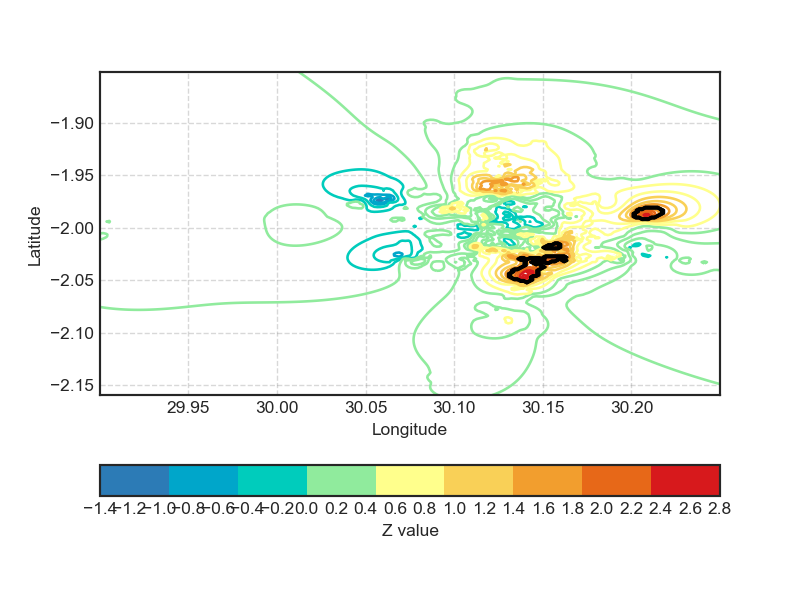

In [26]:
# Plot the contours
plot_contours(df = df_final, level = "z_val", sig_level = 0.05)

### 3.3 Conditional on Time <a class="anchor" id="time-comparison"></a>
Does not seem to depend on time.

In [3]:
# Path to data
os.chdir("C:/Users/eminu/OneDrive/Desktop/Air-Quality-StatsLab/Data/Rawdata")

# Read in the objects
with open("dictionary_mean.pkl", "rb") as file:
    mean_values_di = pickle.load(file)

with open("dictionary_var.pkl", "rb") as file:
    var_values_di = pickle.load(file)
    
df_final = pd.read_csv("df_res.csv")

<IPython.core.display.Javascript object>


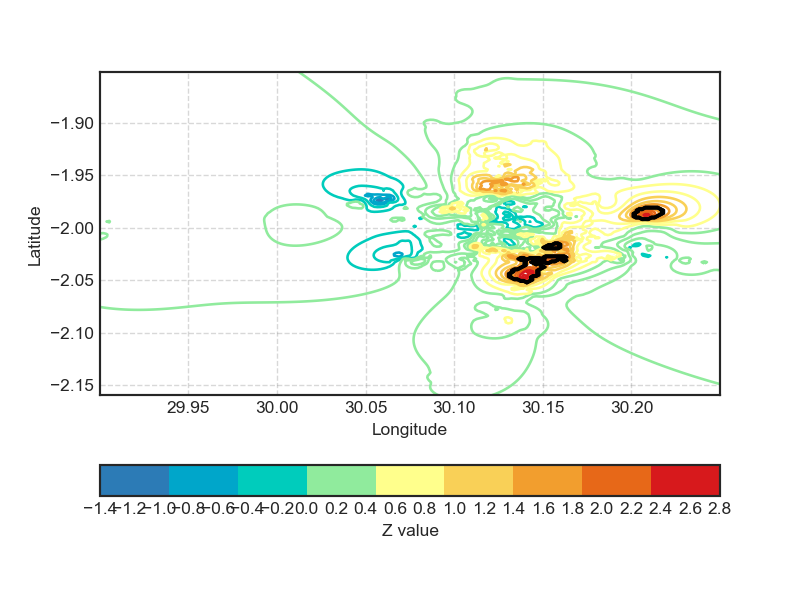

In [39]:
# Plot 06:00:00
plot_contours(df = results_per_time_bracket(response = "pm25_detrended_15", grid = 200, bracket = "06:00:00",
                                            dict_mean = mean_values_di, dict_var = var_values_di),
              level = "z_val", sig_level = 0.05)

<IPython.core.display.Javascript object>


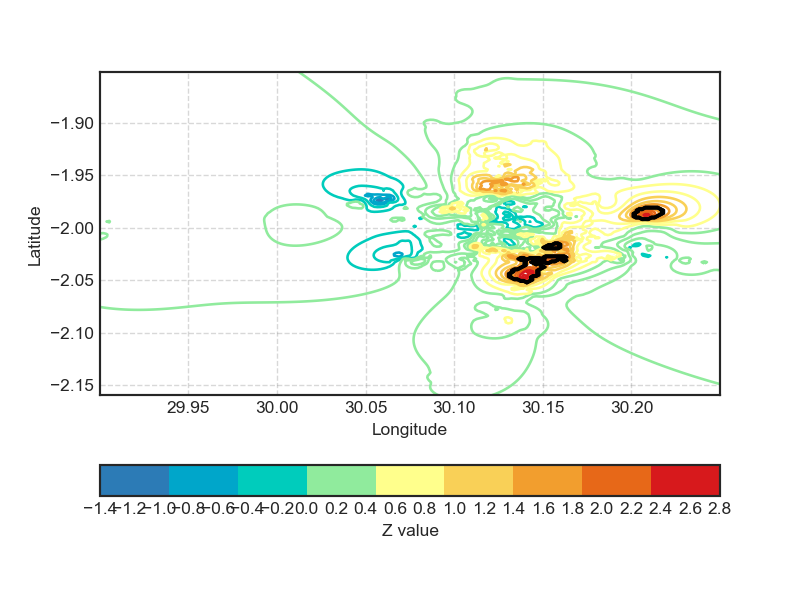

In [40]:
# Plot 08:00:00
plot_contours(df = results_per_time_bracket(response = "pm25_detrended_15", grid = 200, bracket = "08:00:00",
                                            dict_mean = mean_values_di, dict_var = var_values_di),
              level = "z_val", sig_level = 0.05)

<IPython.core.display.Javascript object>


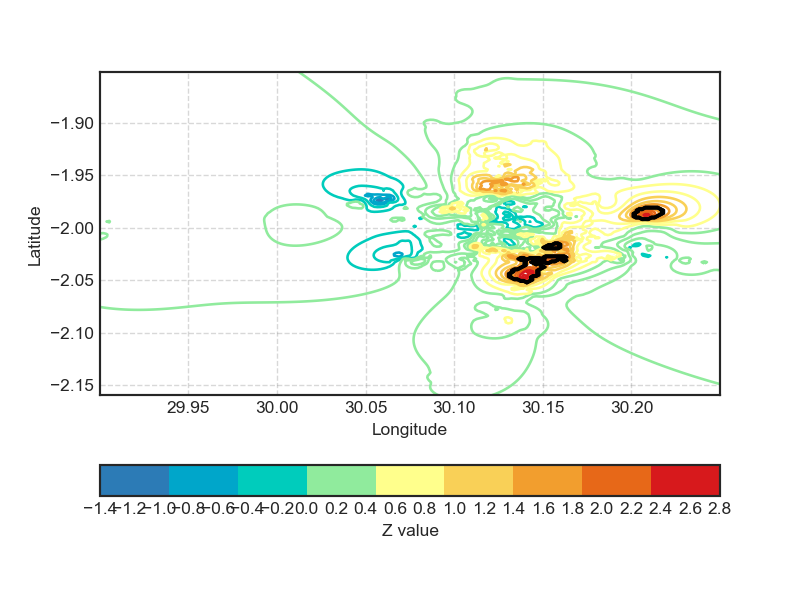

In [41]:
# Plot 18:00:00
plot_contours(df = results_per_time_bracket(response = "pm25_detrended_15", grid = 200, bracket = "18:00:00",
                                            dict_mean = mean_values_di, dict_var = var_values_di),
              level = "z_val", sig_level = 0.05)